<a href="https://colab.research.google.com/github/j-alex-larrimore/febclasstest/blob/main/California_Real_Estate_(Not_Done).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Just like in the last notebook we need to start with the following steps:

1) Download this dataset which is available at https://www.kaggle.com/camnugent/california-housing-prices

Upload to your Google Drive.

Click on the folder icon on the left, then click on the Mount Drive button.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('drive/MyDrive/ColabDataFolders/Tabular/singapore-flat-prices.csv')
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200


In [ ]:
df.count

<bound method DataFrame.count of           month        town  ... lease_commence_date resale_price
0       1990-01  ANG MO KIO  ...                1977         9000
1       1990-01  ANG MO KIO  ...                1977         6000
2       1990-01  ANG MO KIO  ...                1977         8000
3       1990-01  ANG MO KIO  ...                1977         6000
4       1990-01  ANG MO KIO  ...                1976        47200
...         ...         ...  ...                 ...          ...
287191  1999-12      YISHUN  ...                1987       456000
287192  1999-12      YISHUN  ...                1988       408000
287193  1999-12      YISHUN  ...                1988       469000
287194  1999-12      YISHUN  ...                1988       440000
287195  1999-12      YISHUN  ...                1988       484000

[287196 rows x 10 columns]>

In [ ]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')

In [ ]:
cat_cols = ['town', 'flat_type', 'block', 'flat_model', 'street_name', 'month']
cont_cols = ['floor_area_sqm', 'lease_commence_date']
label_col = ['resale_price']

In [ ]:
df.drop(['storey_range'], axis=1, inplace=True)

In [ ]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [ ]:
df.dtypes

month                  category
town                   category
flat_type              category
block                  category
street_name            category
floor_area_sqm          float64
flat_model             category
lease_commence_date       int64
resale_price              int64
dtype: object

In [ ]:
df['town'].cat.categories

Index(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'LIM CHU KANG', 'MARINE PARADE', 'PASIR RIS',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'],
      dtype='object')

In [ ]:
df['town'].head().cat.codes

0    0
1    0
2    0
3    0
4    0
dtype: int8

In [ ]:
cont_cols

['floor_area_sqm', 'lease_commence_date']

In [ ]:
df['floor_area_sqm']

0          31.0
1          31.0
2          31.0
3          31.0
4          73.0
          ...  
287191    142.0
287192    142.0
287193    146.0
287194    146.0
287195    145.0
Name: floor_area_sqm, Length: 287196, dtype: float64

In [ ]:
for cont in cont_cols:
    df[cont] = pd.to_numeric(df[cont], errors='coerce')

In [ ]:
df.dropna(inplace=True)
df.count

<bound method DataFrame.count of           month        town  ... lease_commence_date resale_price
0       1990-01  ANG MO KIO  ...                1977         9000
1       1990-01  ANG MO KIO  ...                1977         6000
2       1990-01  ANG MO KIO  ...                1977         8000
3       1990-01  ANG MO KIO  ...                1977         6000
4       1990-01  ANG MO KIO  ...                1976        47200
...         ...         ...  ...                 ...          ...
287191  1999-12      YISHUN  ...                1987       456000
287192  1999-12      YISHUN  ...                1988       408000
287193  1999-12      YISHUN  ...                1988       469000
287194  1999-12      YISHUN  ...                1988       440000
287195  1999-12      YISHUN  ...                1988       484000

[287196 rows x 9 columns]>

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)
cats = torch.tensor(cats, dtype=torch.int64)
cats[:5]

tensor([[  3,   2, 185,   8,  50, 101],
        [  9,   2, 264,   8, 103,  90],
        [  8,   3, 385,   5,  87, 109],
        [  3,   2,  96,   8,  63,  33],
        [ 12,   2, 259,   2, 351, 101]])

In [ ]:
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[  67., 1985.],
        [  67., 1979.],
        [ 123., 1992.],
        [  82., 1985.],
        [  74., 1977.]])

In [ ]:
labels = torch.tensor(df[label_col].values, dtype=torch.float).view(-1, 1)

In [ ]:
labels.shape, labels.dtype

(torch.Size([287196, 1]), torch.float32)

In [ ]:
class BasicModel(nn.Module):
    def __init__(self, in_features=8, h1=20, h2=40, out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [ ]:
model = BasicModel()
torch.manual_seed(43)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [ ]:
batch_size = 287196
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = labels[:batch_size-test_size]
y_test = labels[batch_size-test_size:batch_size]

x_train = torch.cat((cat_train, con_train), 1)
x_test = torch.cat((cat_test, con_test), 1)

In [ ]:
epochs = 1500
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(x_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%100 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


epoch:  1  loss: 254161.90625000
epoch: 101  loss: 61732.66406250
epoch: 201  loss: 57793.18750000
epoch: 301  loss: 57834.05468750
epoch: 401  loss: 57601.41015625
epoch: 501  loss: 57507.34375000
epoch: 601  loss: 57346.40234375
epoch: 701  loss: 57272.17578125
epoch: 801  loss: 57114.17187500
epoch: 901  loss: 56871.04296875
epoch: 1001  loss: 39939.62890625
epoch: 1101  loss: 36630.97656250
epoch: 1201  loss: 36345.01562500
epoch: 1301  loss: 36240.55859375
epoch: 1401  loss: 36410.41796875


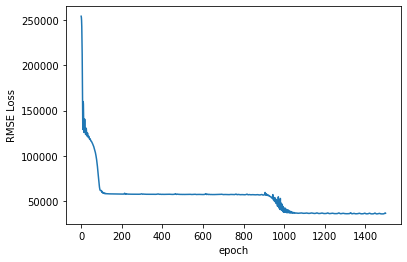

In [ ]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [ ]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(x_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 36408.42187500


In [ ]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1. 108385.2422 122000.0000 13614.7578
 2. 402230.0000 354000.0000 48230.0000
 3. 403478.0000 329000.0000 74478.0000
 4. 153048.8750 142000.0000 11048.8750
 5. 360904.5000 405000.0000 44095.5000
 6. 382181.9375 335000.0000 47181.9375
 7. 313505.0625 405000.0000 91494.9375
 8. 114366.7891 152000.0000 37633.2109
 9. 126568.2969 140000.0000 13431.7031
10. 181379.5312 202000.0000 20620.4688
11. 419092.0625 460000.0000 40907.9375
12. 151018.3438 145000.0000 6018.3438
13. 156321.1562 131500.0000 24821.1562
14. 321616.5000 315000.0000 6616.5000
15. 361903.0625 330000.0000 31903.0625
16. 204409.0938 166000.0000 38409.0938
17. 266213.7500 253000.0000 13213.7500
18. 358194.7812 370000.0000 11805.2188
19. 247517.3750 208000.0000 39517.3750
20. 386877.6562 363000.0000 23877.6562
21. 241576.1875 280000.0000 38423.8125
22. 96920.9844 116000.0000 19079.0156
23. 163435.6719 162500.0000 935.6719
24. 354918.6250 400000.0000 45081.3750
25. 93400.9297 80000.0000 13400.9297
2